<a href="https://colab.research.google.com/github/ganeshhep/FCC/blob/main/comparison_strange_frag_tag_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install fastjet
!pip install uproot

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.9/80.9 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 879.3/879.3 kB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 638.7/638.7 kB 22.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.8/177.8 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.0/365.0 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 12.8 MB/s eta 0:00:00


In [2]:
import uproot
import awkward as ak
import itertools
from fastjet import PseudoJet, JetDefinition, ClusterSequence, antikt_algorithm, sorted_by_pt
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

In [3]:
from google.colab import drive
drive.mount('/content/drive')
data_file_1 = '/content/drive/MyDrive/ML_HEP/Data_files/fcc_ee_h_ss.root'
data_file_2 = '/content/drive/MyDrive/ML_HEP/Data_files/fcc_ee_h_qq.root'
tree_1 = uproot.open(data_file_1)['events']
tree_2 = uproot.open(data_file_2)['events']

Mounted at /content/drive


In [4]:
pid = ak.concatenate([tree_1['Particle.PDG'].array(), tree_2['Particle.PDG'].array()], axis = 0)
p_status = ak.concatenate([tree_1['Particle.generatorStatus'].array(), tree_2['Particle.generatorStatus'].array()], axis = 0)
charge = ak.concatenate([tree_1['Particle.charge'].array(), tree_2['Particle.charge'].array()], axis = 0)
m = ak.concatenate([tree_1['Particle.mass'].array(), tree_2['Particle.mass'].array()], axis = 0)
px = ak.concatenate([tree_1['Particle.momentum.x'].array(), tree_2['Particle.momentum.x'].array()], axis = 0)
py = ak.concatenate([tree_1['Particle.momentum.y'].array(), tree_2['Particle.momentum.y'].array()], axis = 0)
pz = ak.concatenate([tree_1['Particle.momentum.z'].array(), tree_2['Particle.momentum.z'].array()], axis = 0)
p_begin = ak.concatenate([tree_1['Particle.parents_begin'].array(), tree_2['Particle.parents_begin'].array()], axis = 0)
p_end = ak.concatenate([tree_1['Particle.parents_end'].array(), tree_2['Particle.parents_end'].array()], axis = 0)
p_ind = ak.concatenate([tree_1['Particle#0.index'].array(), tree_2['Particle#0.index'].array()], axis = 0)

In [5]:
# Function to calculate energy
def energy(m, px, py, pz):
    E = np.sqrt(m**2 + px**2 + py**2 + pz**2)
    return E

In [6]:
e = energy(m, px, py, pz) # Energy of particles

In [7]:
def get_parent_indx(i, particle_ids, parent_indices, parents_begin, parents_end):
    """
    Find parent ID and it's index in the particle IDs list.

    Parameters:
        i (integer): Index of the stable particle.
        particle_ids (list): A list of particle IDs.
        parent_indices (list): A list of parent indices of particles.
        parents_begin (list): A list of indices of the first parent of each particle.
        parents_end (list): A list of indices of the last parent of each particle.

    Returns:
        parent_indx (integer): Index of the parent particle.
    """
    pb = int(parents_begin[i])
    pe = int(parents_end[i])

    parent_ind = []

    if pb == pe :
        parent_ind.append(-999)
        return parent_ind
    else :
        for ind in range(pb, pe):
            indx = int(parent_indices[ind])  # Access parent_indices using ind
            parent_ind.append(int(indx))
        return parent_ind

In [8]:
def find_repeated_lists(list_of_lists):
    """
    Find indices of lists that appear twice or more in the given list of lists.

    Parameters:
        list_of_lists (list of lists): The input list of lists.

    Returns:
        dict: A dictionary where keys are the repeated lists (as tuples) and values are lists of their indices.
    """
    seen = defaultdict(list)  # Dictionary to store indices of each list (as tuple)

    # Store indices of each unique list
    for idx, sublist in enumerate(list_of_lists):
        seen[tuple(sublist)].append(idx)

    # Filter only repeated lists
    repeated = {k: v for k, v in seen.items() if len(v) > 1}

    return repeated

In [9]:
def get_pd_ids(stable_indx, particle_ids, parent_indices, parents_begin, parents_end):
    """
    Identifies particles with shared parents and groups their IDs.

    This function finds particles that have the same parent indices and collects
    their IDs along with their parent IDs.

    Parameters:
        stable_indx (list): A list of indices of stable particles.
        particle_ids (list): A list of particle IDs.
        parent_ind_list (list of lists): A list where each sublist contains
                                       the parent indices of a particle.

    Returns:
        list of lists: A list where each sublist contains the parent IDs and
                       the IDs of particles sharing those parents.
                       Format: [[parent_id1, parent_id2, ..., [daughter_id1, daughter_id2, ...]], ...]
    """
    parent_ind_list = []
    for i in stable_indx :
        parent_ind_list.append(get_parent_indx(i, particle_ids, parent_indices, parents_begin, parents_end))

    pd_id_list = []  # Initialize the list to store parent-daughter ID groups

    sparent_indx = [] # This list contains index of Ks meson, lambda baryon and lambdabar baryon.

    # Find repeated parent index lists and their indices
    result = find_repeated_lists(parent_ind_list)

    # Iterate through the repeated parent index lists
    for key, indices in result.items():
        parents = []  # List to store parent IDs for the current group
        daughters = []  # List to store daughter IDs for the current group
        parent_list = list(key)  # Convert the tuple key to a list, a list with parent index

        # Get parent IDs using parent indices
        for ind_1 in parent_list :
            if int(particle_ids[ind_1]) == 310 or int(particle_ids[ind_1]) == 3122 or int(particle_ids[ind_1]) == -3122 :
              sparent_indx.append(ind_1)
              parents.append(int(particle_ids[ind_1]))
              for ind_2 in indices :
                daughters.append(int(particle_ids[stable_indx[ind_2]])) # Get daughter IDs using the indices where the parent list appears
              j = get_parent_indx(ind_1, particle_ids, parent_indices, parents_begin, parents_end)
              while j[0] != -999 :
                parents.append(int(particle_ids[j[0]]))
                k = get_parent_indx(j[0], particle_ids, parent_indices, parents_begin, parents_end)
                j[0] = k[0]

              # Combine parent and daughter IDs for the current group
              parents.append(daughters)
              pd_id_list.append(parents)  # Add the group to the main list

    return pd_id_list, sparent_indx  # Return the list of parent-daughter ID groups and special parent indices

In [10]:
def contains_any_group(lst):
    groups = [
        {310, 3, frozenset([211, -211])},
        {310, -3, frozenset([211, -211])},
        {310, 3, frozenset([111, 111])},
        {310, -3, frozenset([111, 111])},
        {3122, 3, frozenset([2212, -211])},
        {3122, -3, frozenset([2212, -211])},
        {3122, 3, frozenset([2112, 111])},
        {3122, -3, frozenset([2112, 111])},
        {-3122, 3, frozenset([-2212, 211])},
        {-3122, -3, frozenset([-2212, 211])},
        {-3122, 3, frozenset([-2112, 111])},
        {-3122, -3, frozenset([-2112, 111])}
    ]

    # Convert input list to a set, ensuring lists are stored as frozen sets
    lst_as_set = {frozenset(x) if isinstance(x, list) else x for x in lst}

    return any(group.issubset(lst_as_set) for group in groups)

In [11]:
def get_comparison(R) : # R is the radius parameter
  d1_pt = [] # Dijet pt
  d1_eta = [] # Dijet eta
  d1_e = [] # Dijet energy
  d1_N = [] # Number of constituents of dijet
  photon_e_1 = [] # Photon energy
  muon_e_1 = [] # Muon energy
  electron_e_1 = [] # Electron energy
  Ks_e_1 = [] # Reconstructed Ks energy
  lambda_e_1 = [] # Reconstructed Lambda energy
  lambdabar_e_1 = [] # Reconstructed Lambdabar energy
  photon_cnt_1 = [] # Number of photons in the dijet
  muon_cnt_1 = [] # Number of muons in the dijet
  electron_cnt_1 = [] # Number of electrons in the dijet
  Ks_cnt_1 = [] # Number of Ks mesons in the dijet
  lambda_cnt_1 = [] # Number of lambda baryons in the dijet
  lambdabar_cnt_1 = [] # Number of lambdabar baryons in the dijet
  mes_cnt_1 = [] # Number of strange mesons in the dijet (Ks)
  bar_cnt_1 = [] # Number of strange baryons in the dijet (lambda or lambdabar)

  d2_pt = []
  d2_eta = []
  d2_e = []
  d2_N = []
  photon_e_2 = []
  muon_e_2 = []
  electron_e_2 = []
  Ks_e_2 = []
  lambda_e_2 = []
  lambdabar_e_2 = []
  photon_cnt_2 = []
  muon_cnt_2 = []
  electron_cnt_2 = []
  Ks_cnt_2 = []
  lambda_cnt_2 = []
  lambdabar_cnt_2 = []
  mes_cnt_2 = []
  bar_cnt_2 = []

  for n in range(100000):
    particles_list_1 = [] # A list of all the particles in an event

    constituent_indx_1 = [] # A list of indices of constitents of the dijet

    parent_indices_1 = [] # A list of parent indices of constitents of the dijet

    photon_energy_1 = 0 # Total photon energy
    muon_energy_1 = 0 # Total muon energy
    electron_energy_1 = 0 # Total electron energy
    Ks_energy_1 = 0 # Total reconstructed Ks meson energy
    lambda_energy_1 = 0 # Total reconstructed lambda baryon energy
    lambdabar_energy_1 = 0 # Total reconstructed lambdabar baryon energy

    photon_count_1 = 0 # Photon count
    muon_count_1 = 0 # Muon count
    electron_count_1 = 0 # Electron count
    lambda_count_1 = 0 # Lambda baryon count
    lambdabar_count_1 = 0 # Lambdabar baryon count
    Ks_count_1 = 0 # Ks meson count

    sts_1 = p_status[n] # Generator status of particles
    p_x_1 = px[n] # X-momentum of particles
    p_y_1 = py[n] # Y-momentum of particles
    p_z_1 = pz[n] # Z-momentum of particles
    E_1 = e[n] # Energy of particles
    pcharge = charge[n] # Charge of particles
    ids_1 = pid[n] # PDG id of particles
    pinds_1 = p_ind[n] # Parent indices of particles
    pbegin_1 = p_begin[n] # Parent begin indices of particles
    pend_1 = p_end[n] # Parent end indices of particles

    for i in range(len(p_x_1)) :
      part_p4_1 = PseudoJet(float(p_x_1[i]), float(p_y_1[i]), float(p_z_1[i]), float(E_1[i]))
      part_p4_1.set_user_index(i) # setting the index of the particle
      particles_list_1.append(part_p4_1)

    stable_p4_1 = [] # A list of stable particles in the event

    for i in range(len(particles_list_1)) :
      if sts_1[i] == 1 :
        stable_p4_1.append(particles_list_1[i])

    # Applying clustering of particles with anti-kt algorithm
    cluster_1 = ClusterSequence(stable_p4_1, JetDefinition(antikt_algorithm, R))
    jet_set_1 = sorted_by_pt(cluster_1.inclusive_jets())

    if len(jet_set_1) > 1 :
      # Dijet kinematics
      dijet_1 = jet_set_1[0] + jet_set_1[1]
      d_m_1 = dijet_1.m() # invariant mass
      d_pt_1 = dijet_1.pt() # transverse momentum
      d_eta_1 = dijet_1.eta() # pseudo rapidity
      d_e_1 = dijet_1.e() # energy

      Dijet_constituents_1 = jet_set_1[0].constituents() + jet_set_1[1].constituents() # Dijet constituents

      N_constituents_1 = len(Dijet_constituents_1) # Total number of constituents N in the dijet

      d1_pt.append(d_pt_1)
      d1_eta.append(d_eta_1)
      d1_e.append(d_e_1)
      d1_N.append(N_constituents_1)

      for i in range(N_constituents_1) :
        constituent_indx_1.append(Dijet_constituents_1[i].user_index())

      for j in constituent_indx_1 :
        const_id_1 = ids_1[j]

        if const_id_1 == 22 :
          photon_count_1 += 1
          photon_energy_1 += particles_list_1[j].e()
        if const_id_1 == 13 :
          muon_count_1 += 1
          muon_energy_1 += particles_list_1[j].e()
        if const_id_1 == 11 :
          electron_count_1 += 1
          electron_energy_1 += particles_list_1[j].e()

      pd_list_1, sparent_indx_1 = get_pd_ids(constituent_indx_1, ids_1, pinds_1, pbegin_1, pend_1)

      mes_count_1 = 0 # Strange meson count
      bar_count_1 = 0 # Strange baryon count

      for i in range(len(pd_list_1)) :
        if contains_any_group(pd_list_1[i]) :
          if pd_list_1[i][0] == 310 :
            mes_count_1 += 1
            Ks_count_1 += 1
            Ks_ind_1 = sparent_indx_1[i]
            Ks_energy_1 += particles_list_1[Ks_ind_1].e()
          if pd_list_1[i][0] == 3122 :
            bar_count_1 += 1
            lambda_count_1 += 1
            lambda_ind_1 = sparent_indx_1[i]
            lambda_energy_1 += particles_list_1[lambda_ind_1].e()
          if pd_list_1[i][0] == -3122 :
            bar_count_1 += 1
            lambdabar_count_1 += 1
            lambdabar_ind_1 = sparent_indx_1[i]
            lambdabar_energy_1 += particles_list_1[lambdabar_ind_1].e()

      photon_e_1.append(photon_energy_1)
      muon_e_1.append(muon_energy_1)
      electron_e_1.append(electron_energy_1)
      Ks_e_1.append(Ks_energy_1)
      lambda_e_1.append(lambda_energy_1)
      lambdabar_e_1.append(lambdabar_energy_1)

      photon_cnt_1.append(photon_count_1)
      muon_cnt_1.append(muon_count_1)
      electron_cnt_1.append(electron_count_1)
      Ks_cnt_1.append(Ks_count_1)
      lambda_cnt_1.append(lambda_count_1)
      lambdabar_cnt_1.append(lambdabar_count_1)

      mes_cnt_1.append(mes_count_1)
      bar_cnt_1.append(bar_count_1)

    particles_list_2 = [] # A list of all the particles in an event

    constituent_indx_2 = [] # A list of indices of constitents of the dijet

    parent_indices_2 = [] # A list of parent indices of constitents of the dijet

    photon_energy_2 = 0 # Total photon energy
    muon_energy_2 = 0 # Total muon energy
    electron_energy_2 = 0 # Total electron energy
    Ks_energy_2 = 0 # Total reconstructed Ks meson energy
    lambda_energy_2 = 0 # Total reconstructed lambda baryon energy
    lambdabar_energy_2 = 0 # Total reconstructed lambdabar baryon energy

    photon_count_2 = 0 # Photon count
    muon_count_2 = 0 # Muon count
    electron_count_2 = 0 # Electron count
    lambda_count_2 = 0 # Lambda baryon count
    lambdabar_count_2 = 0 # Lambdabar baryon count
    Ks_count_2 = 0 # Ks meson count

    sts_2 = p_status[100000 + n] # Generator status of particles
    p_x_2 = px[100000 + n] # X-momentum of particles
    p_y_2 = py[100000 + n] # Y-momentum of particles
    p_z_2 = pz[100000 + n] # Z-momentum of particles
    E_2 = e[100000 + n] # Energy of particles
    ids_2 = pid[100000 + n] # PDG id of particles
    pinds_2 = p_ind[100000 + n] # Parent indices of particles
    pbegin_2 = p_begin[100000 + n] # Parent begin indices of particles
    pend_2 = p_end[100000 + n] # Parent end indices of particles

    for i in range(len(p_x_2)) :
      part_p4_2 = PseudoJet(float(p_x_2[i]), float(p_y_2[i]), float(p_z_2[i]), float(E_2[i]))
      part_p4_2.set_user_index(i) # setting the index of the particle
      particles_list_2.append(part_p4_2)

    stable_p4_2 = [] # A list of stable particles in the event

    for i in range(len(particles_list_2)) :
      if sts_2[i] == 1 :
        stable_p4_2.append(particles_list_2[i])

    # Applying clustering of particles with anti-kt algorithm
    cluster_2 = ClusterSequence(stable_p4_2, JetDefinition(antikt_algorithm, R))
    jet_set_2 = sorted_by_pt(cluster_2.inclusive_jets())

    if len(jet_set_2) > 1 :
      # Dijet kinematics
      dijet_2 = jet_set_2[0] + jet_set_2[1]
      d_m_2 = dijet_2.m() # invariant mass
      d_pt_2 = dijet_2.pt() # transverse momentum
      d_eta_2 = dijet_2.eta() # pseudo rapidity
      d_e_2 = dijet_2.e() # energy

      Dijet_constituents_2 = jet_set_2[0].constituents() + jet_set_2[1].constituents() # Dijet constituents

      N_constituents_2 = len(Dijet_constituents_2) # Total number of constituents N in the dijet

      d2_pt.append(d_pt_2)
      d2_eta.append(d_eta_2)
      d2_e.append(d_e_2)
      d2_N.append(N_constituents_2)

      for i in range(N_constituents_2) :
        constituent_indx_2.append(Dijet_constituents_2[i].user_index())

      for j in constituent_indx_2 :
        const_id_2 = ids_2[j]

        if const_id_2 == 22 :
          photon_count_2 += 1
          photon_energy_2 += particles_list_2[j].e()
        if const_id_2 == 13 :
          muon_count_2 += 1
          muon_energy_2 += particles_list_2[j].e()
        if const_id_2 == 11 :
          electron_count_2 += 1
          electron_energy_2 += particles_list_2[j].e()

      pd_list_2, sparent_indx_2 = get_pd_ids(constituent_indx_2, ids_2, pinds_2, pbegin_2, pend_2)

      mes_count_2 = 0 # Strange meson count
      bar_count_2 = 0 # Strange baryon count

      for i in range(len(pd_list_2)) :
        if contains_any_group(pd_list_2[i]) :
          if pd_list_2[i][0] == 310 :
            mes_count_2 += 1
            Ks_count_2 += 1
            Ks_ind_2 = sparent_indx_2[i]
            Ks_energy_2 += particles_list_2[Ks_ind_2].e()
          if pd_list_2[i][0] == 3122 :
            bar_count_2 += 1
            lambda_count_2 += 1
            lambda_ind_2 = sparent_indx_2[i]
            lambda_energy_2 += particles_list_2[lambda_ind_2].e()
          if pd_list_2[i][0] == -3122 :
            bar_count_2 += 1
            lambdabar_count_2 += 1
            lambdabar_ind_2 = sparent_indx_2[i]
            lambdabar_energy_2 += particles_list_2[lambdabar_ind_2].e()

      photon_e_2.append(photon_energy_2)
      muon_e_2.append(muon_energy_2)
      electron_e_2.append(electron_energy_2)
      Ks_e_2.append(Ks_energy_2)
      lambda_e_2.append(lambda_energy_2)
      lambdabar_e_2.append(lambdabar_energy_2)

      photon_cnt_2.append(photon_count_2)
      muon_cnt_2.append(muon_count_2)
      electron_cnt_2.append(electron_count_2)
      Ks_cnt_2.append(Ks_count_2)
      lambda_cnt_2.append(lambda_count_2)
      lambdabar_cnt_2.append(lambdabar_count_2)

      mes_cnt_2.append(mes_count_2)
      bar_cnt_2.append(bar_count_2)

  return d1_pt, d1_eta, d1_e, d1_N, photon_e_1, muon_e_1, electron_e_1, Ks_e_1, lambda_e_1, lambdabar_e_1, photon_cnt_1, muon_cnt_1, electron_cnt_1, Ks_cnt_1, lambda_cnt_1, lambdabar_cnt_1, mes_cnt_1, bar_cnt_1, d2_pt, d2_eta, d2_e, d2_N, photon_e_2, muon_e_2, electron_e_2, Ks_e_2, lambda_e_2, lambdabar_e_2, photon_cnt_2, muon_cnt_2, electron_cnt_2, Ks_cnt_2, lambda_cnt_2, lambdabar_cnt_2, mes_cnt_2, bar_cnt_2

In [12]:
comp = get_comparison(R = 0.8)

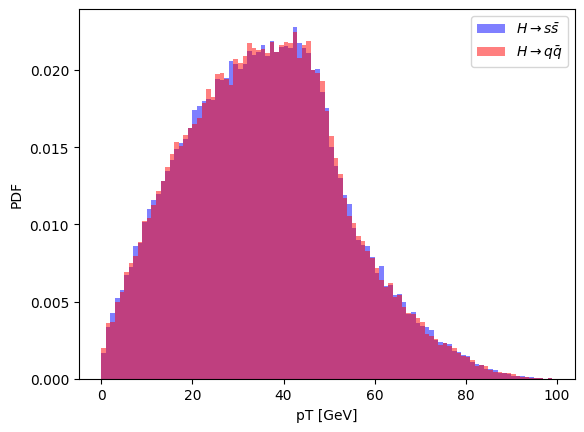

In [13]:
plt.hist(comp[0], bins = np.arange(0, 100), alpha = 0.5, label = r"$H \to s \bar{s}$", color = 'blue', density = True)
plt.hist(comp[18], bins = np.arange(0, 100), alpha = 0.5, label = r"$H \to q \bar{q}$", color = 'red', density = True)
plt.xlabel("pT [GeV]")
plt.ylabel("PDF")
plt.legend()
plt.show()

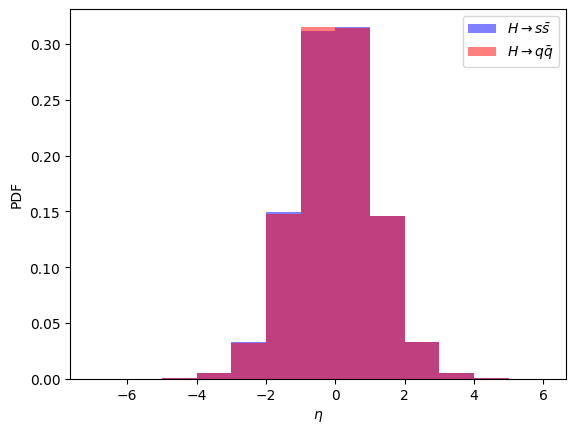

In [14]:
plt.hist(comp[1], bins = np.arange(-7, 7), alpha = 0.5, label = r"$H \to s \bar{s}$", color = 'blue', density = True)
plt.hist(comp[19], bins = np.arange(-7, 7), alpha = 0.5, label = r"$H \to q \bar{q}$", color = 'red', density = True)
plt.xlabel("$\eta$")
plt.ylabel("PDF")
plt.legend()
plt.show()

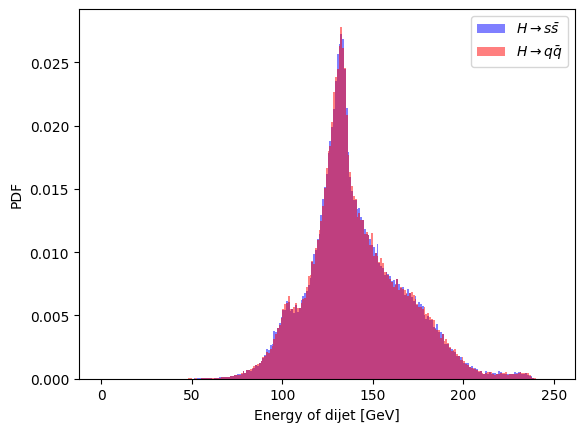

In [15]:
plt.hist(comp[2], bins = np.arange(0, 250), alpha = 0.5, label = r"$H \to s \bar{s}$", color = 'blue', density = True)
plt.hist(comp[20], bins = np.arange(0, 250), alpha = 0.5, label = r"$H \to q \bar{q}$", color = 'red', density = True)
plt.xlabel("Energy of dijet [GeV]")
plt.ylabel("PDF")
plt.legend()
plt.show()

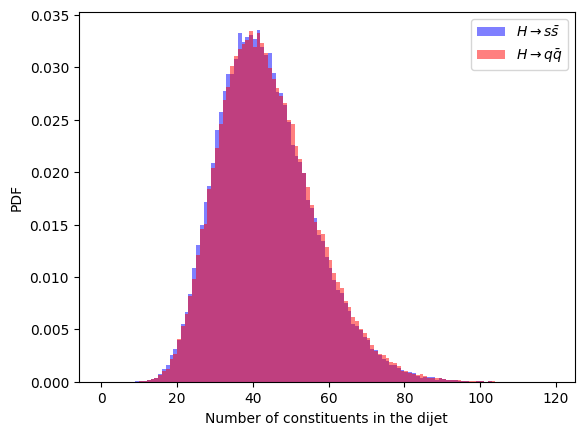

In [16]:
plt.hist(comp[3], bins = np.arange(0, 120), alpha = 0.5, label = r"$H \to s \bar{s}$", color = 'blue', density = True)
plt.hist(comp[21], bins = np.arange(0, 120), alpha = 0.5, label = r"$H \to q \bar{q}$", color = 'red', density = True)
plt.xlabel("Number of constituents in the dijet")
plt.ylabel("PDF")
plt.legend()
plt.show()

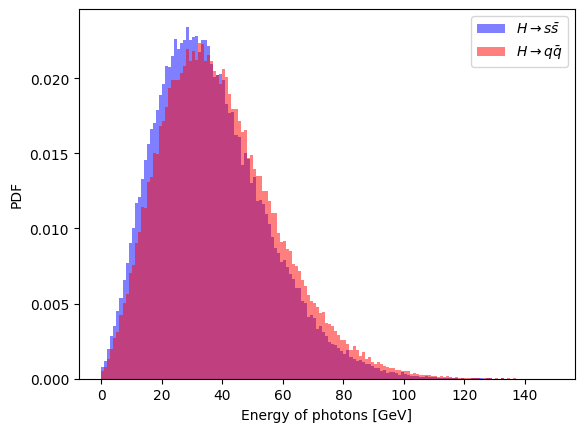

In [17]:
plt.hist(comp[4], bins = np.arange(0, 150), alpha = 0.5, label = r"$H \to s \bar{s}$", color = 'blue', density = True)
plt.hist(comp[22], bins = np.arange(0, 150), alpha = 0.5, label = r"$H \to q \bar{q}$", color = 'red', density = True)
plt.xlabel("Energy of photons [GeV]")
plt.ylabel("PDF")
plt.legend()
plt.show()

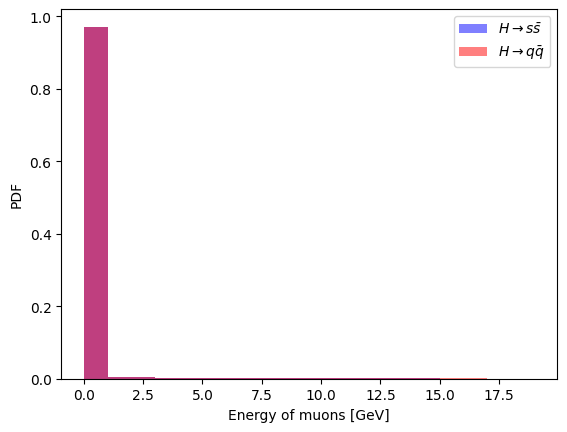

In [18]:
plt.hist(comp[5], bins = np.arange(0, 20), alpha = 0.5, label = r"$H \to s \bar{s}$", color = 'blue', density = True)
plt.hist(comp[23], bins = np.arange(0, 20), alpha = 0.5, label = r"$H \to q \bar{q}$", color = 'red', density = True)
plt.xlabel("Energy of muons [GeV]")
plt.ylabel("PDF")
plt.legend()
plt.show()

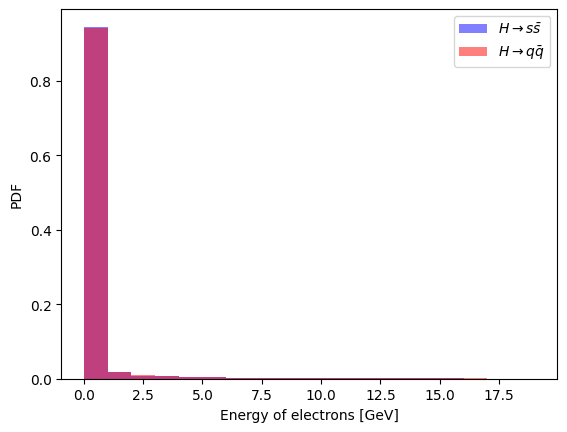

In [19]:
plt.hist(comp[6], bins = np.arange(0, 20), alpha = 0.5, label = r"$H \to s \bar{s}$", color = 'blue', density = True)
plt.hist(comp[24], bins = np.arange(0, 20), alpha = 0.5, label = r"$H \to q \bar{q}$", color = 'red', density = True)
plt.xlabel("Energy of electrons [GeV]")
plt.ylabel("PDF")
plt.legend()
plt.show()

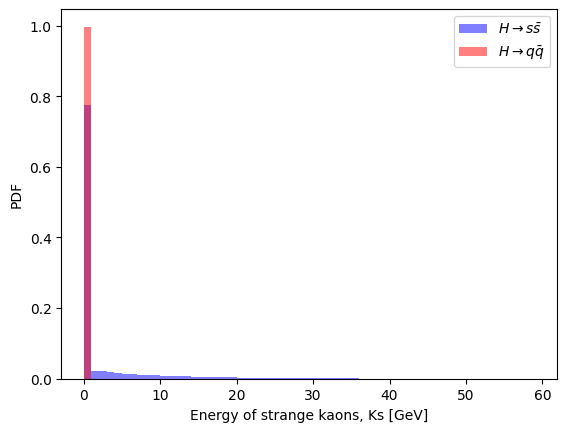

In [20]:
plt.hist(comp[7], bins = np.arange(0, 60), alpha = 0.5, label = r"$H \to s \bar{s}$", color = 'blue', density = True)
plt.hist(comp[25], bins = np.arange(0, 60), alpha = 0.5, label = r"$H \to q \bar{q}$", color = 'red', density = True)
plt.xlabel("Energy of strange kaons, Ks [GeV]")
plt.ylabel("PDF")
plt.legend()
plt.show()

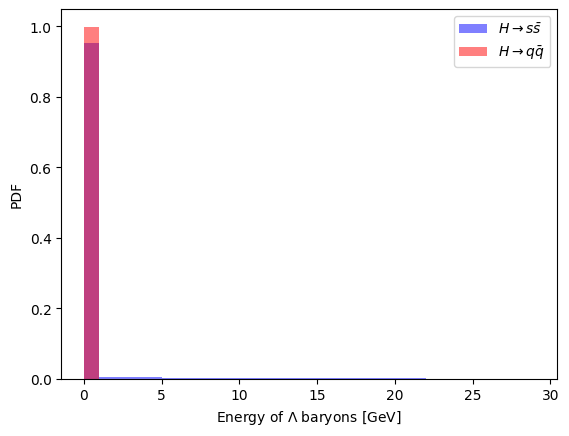

In [21]:
plt.hist(comp[8], bins = np.arange(0, 30), alpha = 0.5, label = r"$H \to s \bar{s}$", color = 'blue', density = True)
plt.hist(comp[26], bins = np.arange(0, 30), alpha = 0.5, label = r"$H \to q \bar{q}$", color = 'red', density = True)
plt.xlabel("Energy of $\Lambda$ baryons [GeV]")
plt.ylabel("PDF")
plt.legend()
plt.show()

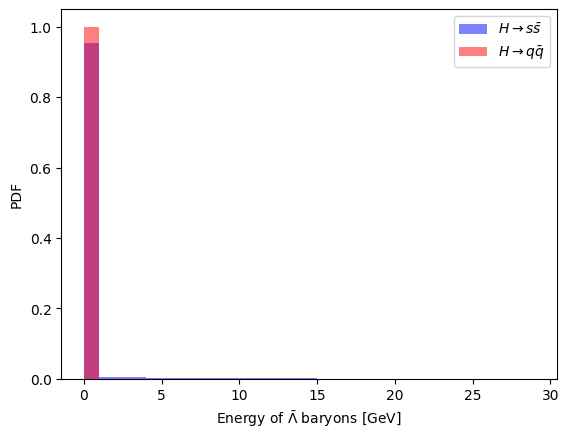

In [22]:
plt.hist(comp[9], bins = np.arange(0, 30), alpha = 0.5, label = r"$H \to s \bar{s}$", color = 'blue', density = True)
plt.hist(comp[27], bins = np.arange(0, 30), alpha = 0.5, label = r"$H \to q \bar{q}$", color = 'red', density = True)
plt.xlabel(r"Energy of $\bar{\Lambda}$ baryons [GeV]")
plt.ylabel("PDF")
plt.legend()
plt.show()

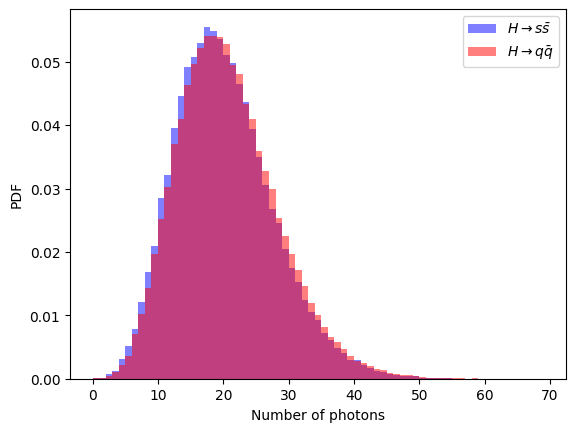

In [23]:
plt.hist(comp[10], bins = np.arange(0, 70), alpha = 0.5, label = r"$H \to s \bar{s}$", color = 'blue', density = True)
plt.hist(comp[28], bins = np.arange(0, 70), alpha = 0.5, label = r"$H \to q \bar{q}$", color = 'red', density = True)
plt.xlabel("Number of photons")
plt.ylabel("PDF")
plt.legend()
plt.show()

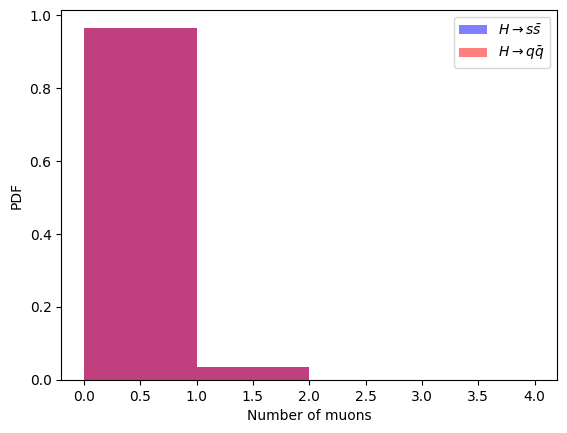

In [24]:
plt.hist(comp[11], bins = np.arange(0, 5), alpha = 0.5, label = r"$H \to s \bar{s}$", color = 'blue', density = True)
plt.hist(comp[29], bins = np.arange(0, 5), alpha = 0.5, label = r"$H \to q \bar{q}$", color = 'red', density = True)
plt.xlabel("Number of muons")
plt.ylabel("PDF")
plt.legend()
plt.show()

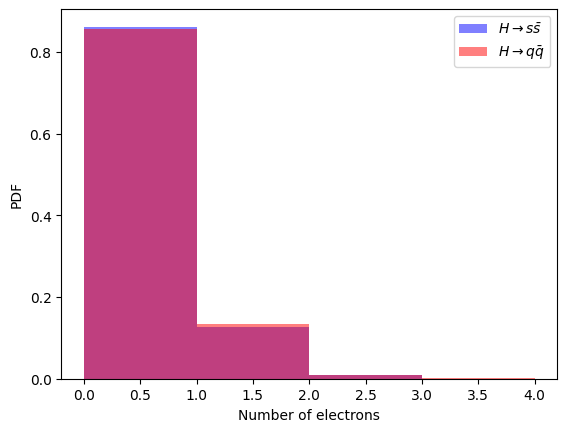

In [25]:
plt.hist(comp[12], bins = np.arange(0, 5), alpha = 0.5, label = r"$H \to s \bar{s}$", color = 'blue', density = True)
plt.hist(comp[30], bins = np.arange(0, 5), alpha = 0.5, label = r"$H \to q \bar{q}$", color = 'red', density = True)
plt.xlabel("Number of electrons")
plt.ylabel("PDF")
plt.legend()
plt.show()

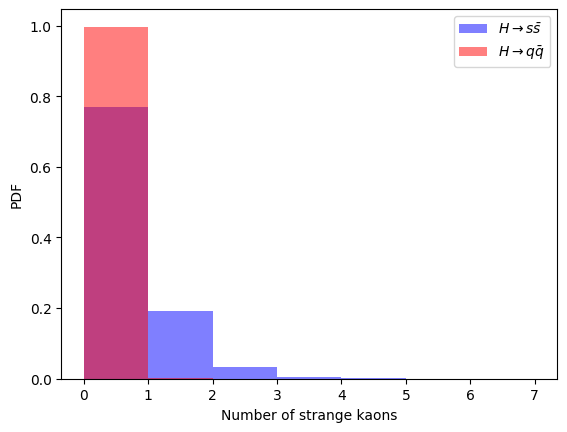

In [26]:
plt.hist(comp[13], bins = np.arange(0, 8), alpha = 0.5, label = r"$H \to s \bar{s}$", color = 'blue', density = True)
plt.hist(comp[31], bins = np.arange(0, 8), alpha = 0.5, label = r"$H \to q \bar{q}$", color = 'red', density = True)
plt.xlabel("Number of strange kaons")
plt.ylabel("PDF")
plt.legend()
plt.show()

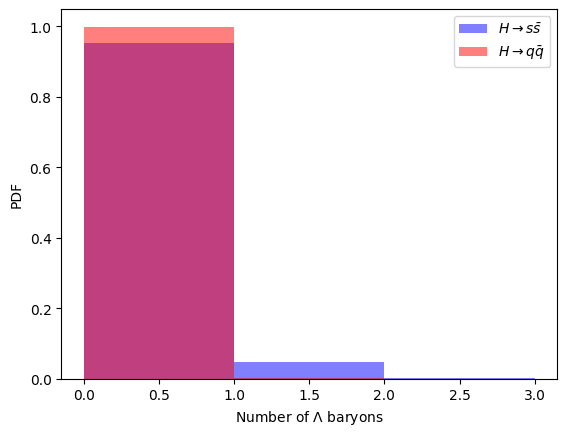

In [27]:
plt.hist(comp[14], bins = np.arange(0, 4), alpha = 0.5, label = r"$H \to s \bar{s}$", color = 'blue', density = True)
plt.hist(comp[32], bins = np.arange(0, 4), alpha = 0.5, label = r"$H \to q \bar{q}$", color = 'red', density = True)
plt.xlabel("Number of $\Lambda$ baryons")
plt.ylabel("PDF")
plt.legend()
plt.show()

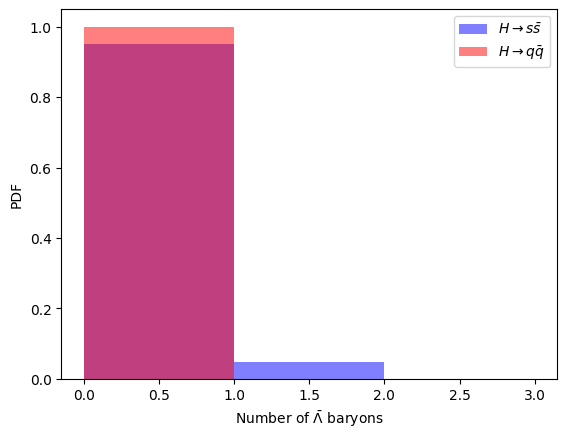

In [28]:
plt.hist(comp[15], bins = np.arange(0, 4), alpha = 0.5, label = r"$H \to s \bar{s}$", color = 'blue', density = True)
plt.hist(comp[33], bins = np.arange(0, 4), alpha = 0.5, label = r"$H \to q \bar{q}$", color = 'red', density = True)
plt.xlabel(r"Number of $\bar{\Lambda}$ baryons")
plt.ylabel("PDF")
plt.legend()
plt.show()

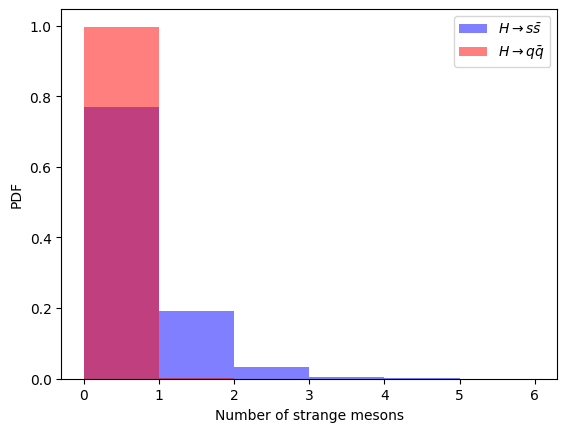

In [29]:
plt.hist(comp[16], bins = np.arange(0, 7), alpha = 0.5, label = r"$H \to s \bar{s}$", color = 'blue', density = True)
plt.hist(comp[34], bins = np.arange(0, 7), alpha = 0.5, label = r"$H \to q \bar{q}$", color = 'red', density = True)
plt.xlabel("Number of strange mesons")
plt.ylabel("PDF")
plt.legend()
plt.show()

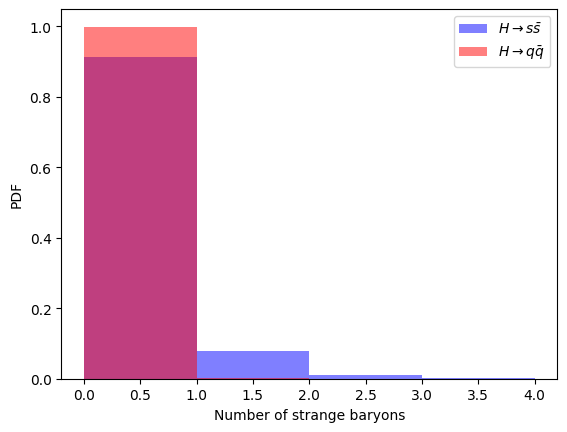

In [30]:
plt.hist(comp[17], bins = np.arange(0, 5), alpha = 0.5, label = r"$H \to s \bar{s}$", color = 'blue', density = True)
plt.hist(comp[35], bins = np.arange(0, 5), alpha = 0.5, label = r"$H \to q \bar{q}$", color = 'red', density = True)
plt.xlabel("Number of strange baryons")
plt.ylabel("PDF")
plt.legend()
plt.show()